In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, log_loss, mean_squared_error
)
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
df = pd.read_csv(r"C:\Users\abhay\Downloads\iris.csv")
df = df.drop(['Unnamed: 0'], axis=1)
df

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [3]:
df.isnull().sum()

Sepal.Length    0
Sepal.Width     0
Petal.Length    0
Petal.Width     0
Species         0
dtype: int64

In [4]:
df.duplicated().sum()

1

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
# Print the rows with duplicates
print(df.duplicated().sum())

0


In [7]:
target = df['Species'].value_counts()
target

Species
setosa        50
versicolor    50
virginica     49
Name: count, dtype: int64

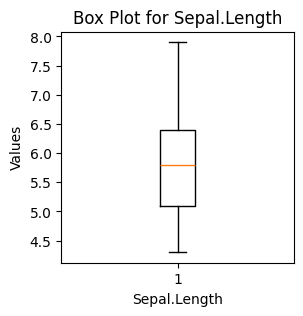

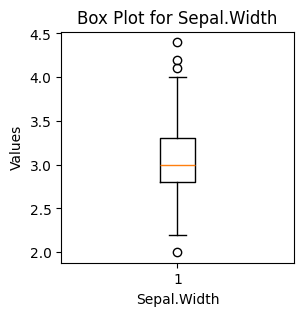

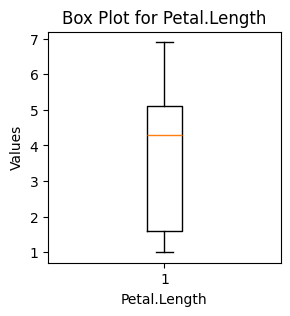

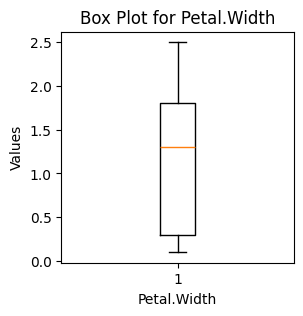

In [8]:
numeric_columns = df.select_dtypes(include='number')

for column in numeric_columns.columns:
    plt.figure(figsize=(3, 3))
    plt.boxplot(numeric_columns[column])
    plt.title(f'Box Plot for {column}')
    plt.xlabel(column)
    plt.ylabel('Values')
plt.show()  

In [9]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

df["Species"] = label_encoder.fit_transform(df["Species"])

In [10]:
X = df.drop(['Species'], axis=1)
Y = df['Species']

In [11]:
Y.value_counts()

Species
0    50
1    50
2    49
Name: count, dtype: int64

In [12]:
# Compute Mutual Information
mutual_info = mutual_info_classif(X, Y)

# Convert the array to a pandas series for easier visualization
mutual_info_series = pd.Series(mutual_info, index = X.columns)

# You can also sort and plot the values for better visualization
mutual_info_series.sort_values(ascending=False) #.plot.bar(figsize=(10, 5))

Petal.Width     0.989062
Petal.Length    0.986399
Sepal.Length    0.518443
Sepal.Width     0.270551
dtype: float64

In [13]:
# Apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=4)
fit = bestfeatures.fit(X,Y)

# Get the scores for each feature
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# Concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Feature','Score']  # naming the dataframe columns

# Print the best features
print(featureScores.nlargest(3,'Score')) # print 10 best features

        Feature       Score
2  Petal.Length  116.164044
3   Petal.Width   66.912137
0  Sepal.Length   10.925388


In [14]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [15]:
# Define the classifiers and their hyperparameter grids
classifiers = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'param_grid': {
            'n_estimators': [10, 50, 100],
            'max_depth': [None, 10, 20],
        }
    },
    'SVM': {
        'model': SVC(),
        'param_grid': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
        }
    },
    'K-Nearest Neighbors': {
        'model': KNeighborsClassifier(),
        'param_grid': {
            'n_neighbors': [3, 5, 7],
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000),
        'param_grid': {
            'C': [0.1, 1, 10],
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'param_grid': {
            'max_depth': [None, 10, 20],
        }
    },
    'Gaussian Naive Bayes': {
        'model': GaussianNB(),
        'param_grid': {}
    }
}

# Model evaluation and metrics
results = {}
for name, config in classifiers.items():
    clf = config['model']
    param_grid = config['param_grid']

    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    # Cross-validation scores
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')

    # Evaluate on the test set
    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        'best_model': best_model,
        'best_params': grid_search.best_params_,
        'mean_cv_accuracy': np.mean(cv_scores),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
    }

# Print the results
for name, result in results.items():
    print(f'{name}:')
    print(f'Best Parameters: {result["best_params"]}')
    print(f'Mean Cross-Validation Accuracy: {result["mean_cv_accuracy"]}')
    print(f'Accuracy on Test Set: {result["accuracy"]}')
    print(f'Precision: {result["precision"]}')
    print(f'Recall: {result["recall"]}')
    print(f'F1 Score: {result["f1_score"]}')
    print(f'Confusion Matrix:\n{result["confusion_matrix"]}\n')

Random Forest:
Best Parameters: {'max_depth': None, 'n_estimators': 10}
Mean Cross-Validation Accuracy: 0.9038095238095238
Accuracy on Test Set: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]

SVM:
Best Parameters: {'C': 1, 'kernel': 'linear'}
Mean Cross-Validation Accuracy: 0.9519047619047619
Accuracy on Test Set: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]

K-Nearest Neighbors:
Best Parameters: {'n_neighbors': 5}
Mean Cross-Validation Accuracy: 0.9233333333333332
Accuracy on Test Set: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]

Logistic Regression:
Best Parameters: {'C': 1}
Mean Cross-Validation Accuracy: 0.9519047619047619
Accuracy on Test Set: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]

Decision Tree:
Best Parameters: {'max_depth': None}
Mean Cross-Validation Acc

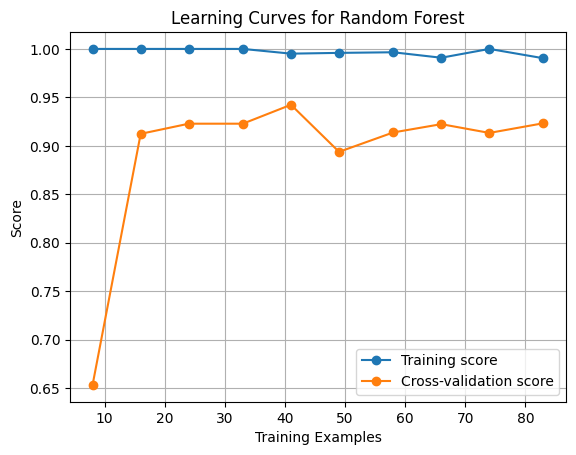

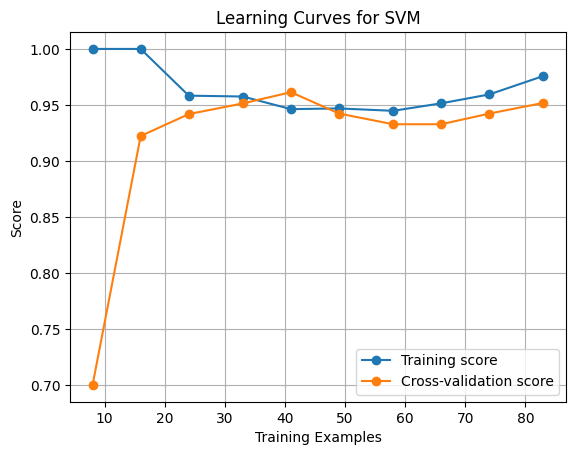

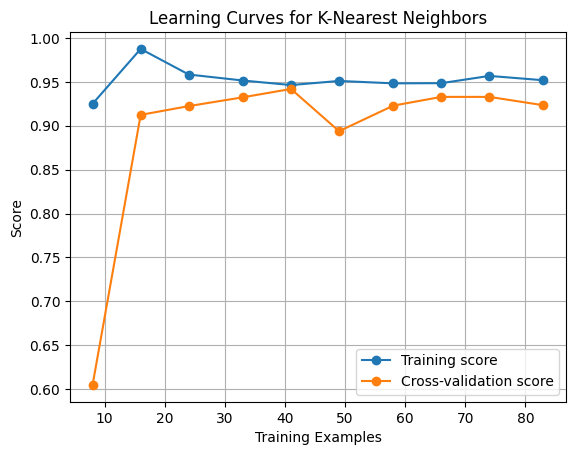

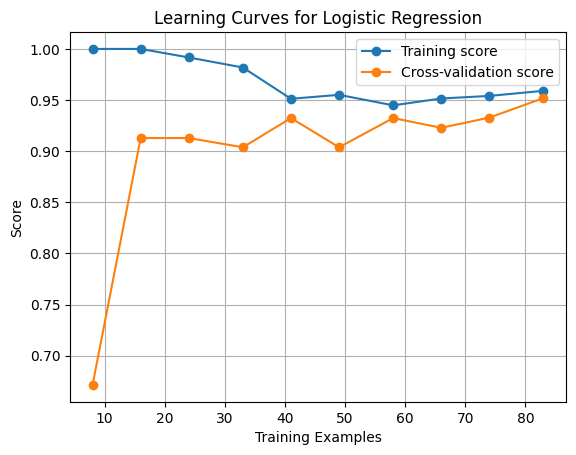

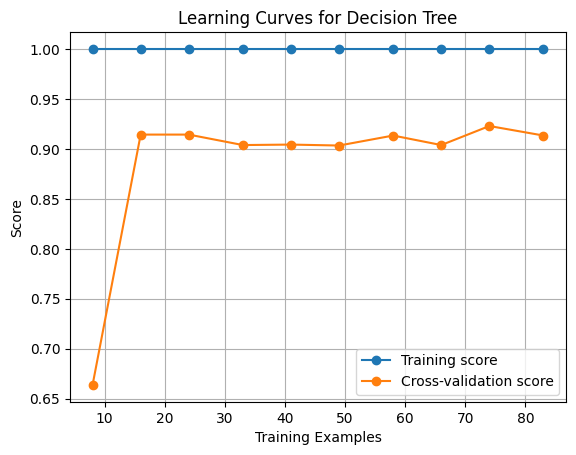

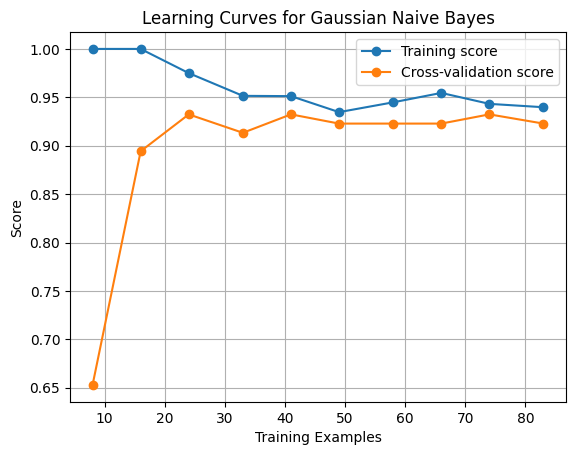

In [16]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Loop through classifiers
for name, result in results.items():
    best_model = result['best_model']
    
    # Calculate learning curves for the best model of each classifier
    train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

    plt.figure()
    plt.title(f"Learning Curves for {name}")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.grid()

    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Cross-validation score")

    plt.legend(loc="best")
plt.show()